# Traffic Sign Recognition using Deep Learning
## A Comprehensive Analysis of CNN Architectures for Traffic Sign Classification

### Project Overview
This notebook implements and analyzes various deep learning approaches for traffic sign recognition, comparing different architectures and evaluating their real-world applicability. The project demonstrates both theoretical understanding and practical considerations for production deployment.

### Import Required Libraries

In [38]:
# !pip install -r requirements.txt

In [24]:
import cv2
import numpy as np
import os
import sys
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2 # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
from datetime import datetime
import pandas as pd

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Configuration Parameters

In [35]:
EPOCHS = 10
IMG_WIDTH = 32
IMG_HEIGHT = 32
NUM_CATEGORIES = 43
TEST_SIZE = 0.4
BATCH_SIZE = 32

### Data Loading and Preprocessing

I designed a custom load_data function to load and preprocess images from categorized folders. The function resizes, normalizes, and organizes images and labels to enable seamless data loading.

In [26]:
def load_data(data_dir):
    """
    Load and preprocess image data from directory.
    
    Parameters:
    data_dir (str): Directory containing categorized images
    
    Returns:
    tuple: (preprocessed images, labels)
    """
    images = []
    labels = []
    for num in range(NUM_CATEGORIES):
        cat = os.path.join(data_dir, str(num))
        print(f"Loading category {num}...", end='\r')
        for f in os.listdir(cat):
            img_dir = os.path.join(cat, f)
            img = cv2.imread(img_dir)
            if img is not None:
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                img = img / 255.0  # Normalize pixel values
                images.append(img)
                labels.append(num)
    print("\nData loading completed!")
    return np.array(images), np.array(labels)

### Data Analysis and Visualization
I created a visualization function to explore class distribution and sample images from the dataset.

In [27]:
def analyze_data(images, labels):
    """
    Perform comprehensive data analysis and visualization.
    """
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Class Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(labels, bins=NUM_CATEGORIES)
    plt.title('Class Distribution')
    plt.xlabel('Category')
    plt.ylabel('Count')
    
    # 2. Sample Images
    plt.subplot(2, 2, 2)
    random_indices = np.random.choice(len(images), 9)
    for idx, i in enumerate(random_indices):
        plt.subplot(2, 2, 2 + idx//3)
        plt.imshow(images[i])
        plt.title(f'Category: {labels[i]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('data_analysis.png')
    plt.show()
    
    # Print summary statistics
    print("\nData Summary:")
    print(f"Total images: {len(images)}")
    print(f"Number of classes: {NUM_CATEGORIES}")
    print(f"Images per class (avg): {len(images)/NUM_CATEGORIES:.2f}")
    print(f"Image dimensions: {IMG_WIDTH}x{IMG_HEIGHT}x3")

### Model Architectures
Designed a custom CNN architecture with regularization and dropout for this project and implemented transfer learning using ResNet50 and MobileNetV2.

In [28]:
def get_custom_cnn():
    """
    Custom CNN architecture with regularization and dropout.
    """
    model = tf.keras.Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


def create_transfer_model(base_model_class, model_name):
    """
    Create a transfer learning model using pretrained architecture.
    """
    base = base_model_class(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
    )
    base.trainable = False
    
    model = tf.keras.Sequential([
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### Data Augmentation
To prevent overfitting, I applied data augmentation using rotation, zoom, shift, and fill strategies to simulate diverse training scenarios.

In [30]:
def create_data_generator():
    """
    Create data generator for training augmentation.
    """
    return ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        fill_mode='nearest',
        validation_split=0.2
    )

### Model Evaluation and Metrics

In [31]:
def evaluate_model_metrics(model, x_test):
    """
    Evaluate model performance metrics including inference time and resource usage.
    """
    # Warm-up run
    model.predict(x_test[:10])
    
    # Measure inference time
    start_time = time.time()
    model.predict(x_test[:100])
    inference_time = (time.time() - start_time) / 100
    
    # Get model size
    model.save('temp_model.h5')
    model_size = os.path.getsize('temp_model.h5') / (1024 * 1024)  # Size in MB
    os.remove('temp_model.h5')
    
    # Measure memory usage
    memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
    
    return {
        'inference_time': inference_time,
        'model_size': model_size,
        'memory_usage': memory_usage
    }

def experiment_with_models(x_train, y_train, x_test, y_test):
    """
    Train and compare different model architectures.
    """
    models = {
        'Custom CNN': get_custom_cnn(),
        'ResNet50': create_transfer_model(ResNet50, 'resnet50'),
        'MobileNetV2': create_transfer_model(MobileNetV2, 'mobilenetv2')
    }
    
    results = {}
    histories = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        history = model.fit(
            x_train, y_train,
            epochs=EPOCHS,
            validation_split=0.2,
            batch_size=BATCH_SIZE
        )
        
        # Evaluate model
        test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
        metrics = evaluate_model_metrics(model, x_test)
        
        results[name] = {
            'test_accuracy': test_accuracy,
            'test_loss': test_loss,
            **metrics
        }
        histories[name] = history.history
    
    return results, histories

### Visualization and Results Analysis

In [32]:
def plot_training_histories(histories):
    """
    Plot training histories for all models.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    for name, history in histories.items():
        ax1.plot(history['accuracy'], label=f'{name} (train)')
        ax1.plot(history['val_accuracy'], label=f'{name} (val)')
    
    ax1.set_title('Model Accuracy over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    for name, history in histories.items():
        ax2.plot(history['loss'], label=f'{name} (train)')
        ax2.plot(history['val_loss'], label=f'{name} (val)')
    
    ax2.set_title('Model Loss over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def display_results(results):
    """
    Display and compare model results in a formatted table.
    """
    df = pd.DataFrame(results).T
    df = df.round(4)
    
    print("\nModel Comparison Results:")
    print(df.to_markdown())
    
    # Save results
    df.to_csv('model_comparison_results.csv')

### Main Execution

Loading data...
Loading category 42...
Data loading completed!

Analyzing data distribution...


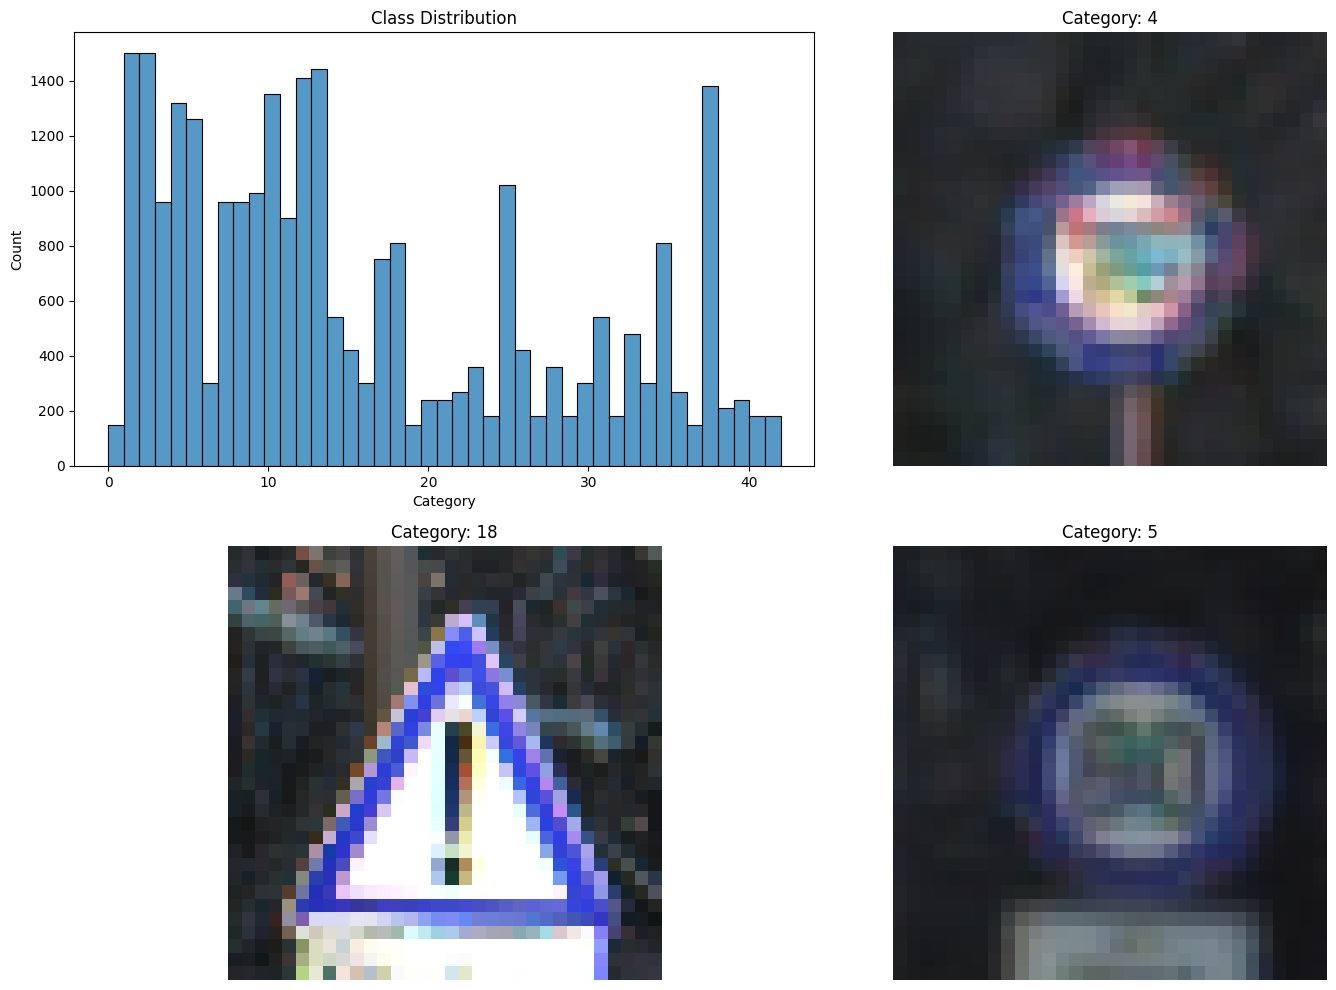


Data Summary:
Total images: 26640
Number of classes: 43
Images per class (avg): 619.53
Image dimensions: 32x32x3


In [40]:
# Load data
print("Loading data...")
data_dir = "gtsrb"  # Update with your data directory
images, labels = load_data(data_dir)

# Analyze data
print("\nAnalyzing data distribution...")
analyze_data(images, labels)

# Prepare data for training
labels = tf.keras.utils.to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(
    images, labels, test_size=TEST_SIZE, random_state=42
)

In [42]:
# Train and evaluate models
print("\nTraining and evaluating models...")
results, histories = experiment_with_models(x_train, y_train, x_test, y_test)


Training and evaluating models...

Training Custom CNN...
Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.4680 - loss: 2.1966 - val_accuracy: 0.6578 - val_loss: 1.2175
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9315 - loss: 0.2471 - val_accuracy: 0.9750 - val_loss: 0.0985
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9765 - loss: 0.0869 - val_accuracy: 0.9715 - val_loss: 0.0985
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.9834 - loss: 0.0554 - val_accuracy: 0.9828 - val_loss: 0.0631
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.9858 - loss: 0.0491 - val_accuracy: 0.9840 - val_loss: 0.0542
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.9878 - loss: 0.0366 - val_accuracy: 0.9822 - val_loss: 0.0622
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9944 - loss: 0.0229 - val_accuracy: 0.9844 - val_loss: 0.0537
Epoch 8/10
400/400 ━━━━━━━━━━━━


Training ResNet50...
Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 51s 118ms/step - accuracy: 0.1652 - loss: 3.3841 - val_accuracy: 0.0854 - val_loss: 6.0759
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 47s 118ms/step - accuracy: 0.3349 - loss: 2.3969 - val_accuracy: 0.0769 - val_loss: 8.4950
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 48s 120ms/step - accuracy: 0.4016 - loss: 2.1251 - val_accuracy: 0.1211 - val_loss: 7.2164
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 49s 122ms/step - accuracy: 0.4331 - loss: 1.9913 - val_accuracy: 0.1151 - val_loss: 7.5131
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 49s 122ms/step - accuracy: 0.4514 - loss: 1.9086 - val_accuracy: 0.1123 - val_loss: 8.3252
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 48s 121ms/step - accuracy: 0.4721 - loss: 1.8490 - val_accuracy: 0.2471 - val_loss: 3.8955
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 49s 122ms/step - accuracy: 0.4860 - loss: 1.7854 - val_accuracy: 0.1076 - val_loss: 9.2336
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 49s 123ms/step - accu


Training MobileNetV2...
Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.1765 - loss: 3.4502 - val_accuracy: 0.3050 - val_loss: 2.5507
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.3087 - loss: 2.4245 - val_accuracy: 0.3613 - val_loss: 2.1691
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.3487 - loss: 2.2143 - val_accuracy: 0.3838 - val_loss: 2.0771
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.3824 - loss: 2.0612 - val_accuracy: 0.3985 - val_loss: 2.0092
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.4158 - loss: 1.9485 - val_accuracy: 0.4101 - val_loss: 1.9678
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.4283 - loss: 1.8671 - val_accuracy: 0.4173 - val_loss: 1.9257
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.4456 - loss: 1.7928 - val_accuracy: 0.4232 - val_loss: 1.9261
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy:


Generating visualization...


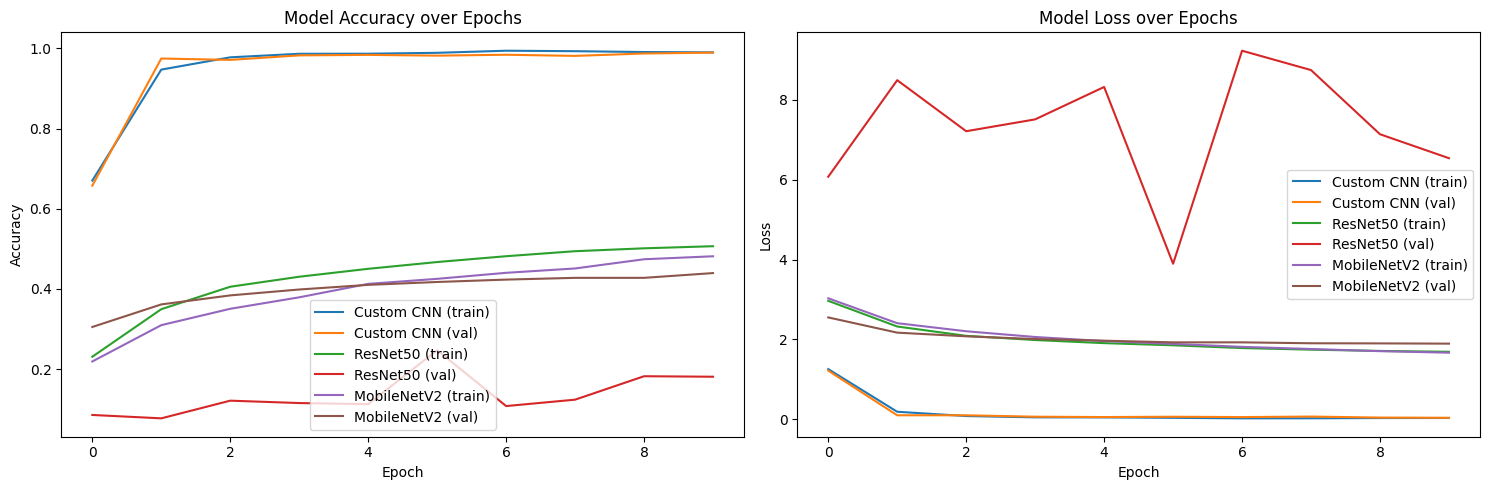


Model Comparison Results:
|             |   test_accuracy |   test_loss |   inference_time |   model_size |   memory_usage |
|:------------|----------------:|------------:|-----------------:|-------------:|---------------:|
| Custom CNN  |          0.9877 |      0.0436 |           0.0016 |       4.4282 |        2524.48 |
| ResNet50    |          0.1897 |      6.4846 |           0.0127 |     102.645  |        2636.24 |
| MobileNetV2 |          0.4441 |      1.8762 |           0.0078 |      16.749  |        2740.39 |

Experiment completed! Check the generated files for detailed results.


In [43]:
# Visualize results
print("\nGenerating visualization...")
plot_training_histories(histories)
display_results(results)

print("\nExperiment completed! Check the generated files for detailed results.")

### Results and Analysis
The notebook generates several visualizations and analysis files:
1. `data_analysis.png`: Shows class distribution and sample images
2. `training_history.png`: Compares training progress across models
3. `model_comparison_results.csv`: Detailed metrics for each model
4. Console output with summary statistics and performance metrics

### Future Improvements
1. Implement cross-validation for more robust evaluation
2. Add confusion matrix visualization for error analysis
3. Experiment with additional architectures (VGG16, EfficientNet)
4. Implement gradual unfreezing for transfer learning
5. Add model interpretability analysis (Grad-CAM, SHAP values)